In [27]:
# Import libraries
%matplotlib inline
import nltk
import string
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import skimage
import itertools

from string import printable
from keras import backend as K
from skimage.transform import resize
from keras.datasets import fashion_mnist
from keras import regularizers
from keras import callbacks
from keras.models import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, Dropout, Activation, Flatten, Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import BatchNormalization, Lambda, Convolution1D, Convolution2D, ELU, concatenate
from keras.layers import Input, Dense,Conv1D, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dropout, Reshape, Embedding, LSTM, GlobalMaxPooling1D
from keras.utils import np_utils
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve, auc
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping  

import warnings
warnings.filterwarnings("ignore")

# 1. Autoencoder

In [3]:
# Load the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data() 

# Normalize the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

y_train = np_utils.to_categorical(y_train, 10, dtype = 'float32') 
y_test = np_utils.to_categorical(y_test, 10, dtype = 'float32') 
print(x_train.shape)
print(x_test.shape)

4423680/4422102 [==============================] - 2s 0us/step
(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [5]:
input_img = Input(shape = (28, 28, 1)) 

x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=(1, 1))(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=(1, 1))(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=(1, 1))(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=(1, 1))(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=(1, 1))(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', strides=(1, 1))(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer = 'adadelta', loss = 'binary_crossentropy')
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 16)          2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 16)          0   

In [6]:
# Training the model
autoencoder_fit = autoencoder.fit(x_train, x_train, epochs = 25, batch_size = 64, validation_data = (x_test, x_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 99s 2ms/step - loss: 0.3348 - val_loss: 0.3226
Epoch 2/25
60000/60000 [==============================] - 94s 2ms/step - loss: 0.3000 - val_loss: 0.2980
Epoch 3/25
60000/60000 [==============================] - 93s 2ms/step - loss: 0.2933 - val_loss: 0.2934
Epoch 4/25
60000/60000 [==============================] - 107s 2ms/step - loss: 0.2893 - val_loss: 0.2871
Epoch 5/25
60000/60000 [==============================] - 103s 2ms/step - loss: 0.2865 - val_loss: 0.2870
Epoch 6/25
60000/60000 [==============================] - 93s 2ms/step - loss: 0.2845 - val_loss: 0.2837
Epoch 7/25
60000/60000 [==============================] - 95s 2ms/step - loss: 0.2829 - val_loss: 0.2838
Epoch 8/25
60000/60000 [==============================] - 95s 2ms/step - loss: 0.2815 - val_loss: 0.2873
Epoch 9/25
60000/60000 [==============================] - 97s 2ms/step - loss: 0.2804 - val_loss: 0.2799
Ep

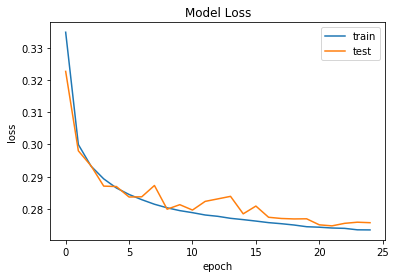

In [8]:
# Plot the loss
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

plot_loss(autoencoder_fit)

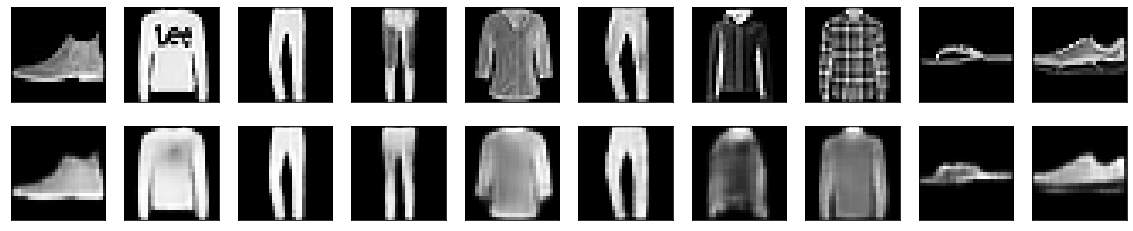

In [12]:
# Display original and recounstruction images
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize = (20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1) 
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Reconstruction
    ax = plt.subplot(2, n, i + n + 1) 
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

# 2. Image Classification


## 2.1 Deep CNN

In [13]:
# Data pre-processing
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

y_train = np_utils.to_categorical(y_train, 10, dtype = "float32")
y_test = np_utils.to_categorical(y_test, 10, dtype = "float32")

In [14]:
# Build convolutional layers
cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', strides=(1, 1), input_shape=(28,28,1)))
cnn.add(MaxPooling2D(pool_size=2))
cnn.add(Dropout(0.3))

cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', strides=(1, 1)))
cnn.add(MaxPooling2D(pool_size=2))
cnn.add(Dropout(0.3))

cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', strides=(1, 1)))
cnn.add(Dropout(0.3))

cnn.add(Flatten())

cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.3))
cnn.add(Dense(10, activation='softmax'))

cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Take a look at the model summary
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 7, 128)        

In [15]:
# Training the model
cnn_fit = cnn.fit(x_train, y_train, batch_size=256, epochs=20, verbose=1, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 65s 1ms/step - loss: 0.6582 - accuracy: 0.7578 - val_loss: 0.4172 - val_accuracy: 0.8473
Epoch 2/20
60000/60000 [==============================] - 66s 1ms/step - loss: 0.4090 - accuracy: 0.8510 - val_loss: 0.3290 - val_accuracy: 0.8786
Epoch 3/20
60000/60000 [==============================] - 65s 1ms/step - loss: 0.3536 - accuracy: 0.8726 - val_loss: 0.3028 - val_accuracy: 0.8872
Epoch 4/20
60000/60000 [==============================] - 66s 1ms/step - loss: 0.3211 - accuracy: 0.8819 - val_loss: 0.2907 - val_accuracy: 0.8935
Epoch 5/20
60000/60000 [==============================] - 69s 1ms/step - loss: 0.2948 - accuracy: 0.8923 - val_loss: 0.2667 - val_accuracy: 0.9005
Epoch 6/20
60000/60000 [==============================] - 69s 1ms/step - loss: 0.2812 - accuracy: 0.8968 - val_loss: 0.2542 - val_accuracy: 0.9059
Epoch 7/20
60000/60000 [==============================] - 68s 1ms/st



[0.21586379125118255, 0.9225999712944031]


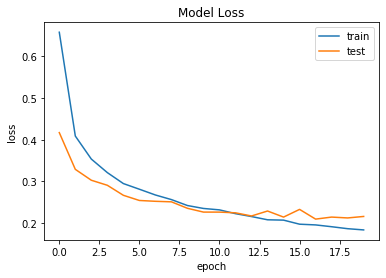

In [16]:
# Get the accuracy
cnn_acc = cnn.evaluate(x_test, y_test, verbose = 0)
print("\n")
print(cnn_acc)

# Plot the loss
plot_loss(cnn_fit)

Based on the results, we can see that the test accuracy of this model is as high as 92.2%, the train accuracy is about 93%, so the model performs very well. It may because I have in total four layers. Also by using dropout, the model does not show an obvious tendency of overfitting.

## 2.2 Transfer Learning

In [17]:
# Data preprocessing
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 784).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 784).astype('float32')

# Convert the images into 3 channels
x_train=np.dstack([x_train] * 3)
x_test=np.dstack([x_test]*3)

x_train = x_train.reshape(x_train.shape[0],28,28,3).astype('float32')
x_test = x_test.reshape(x_test.shape[0],28,28,3).astype('float32')

# Resize images to meet the requirement of VGG16
x_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_train])
x_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_test])

print(x_train.shape) 
print(x_test.shape) 

x_train = x_train / 255
x_test = x_test / 255
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

(60000, 48, 48, 3)
(10000, 48, 48, 3)


In [18]:
x_train = preprocess_input(x_train)
x_test  = preprocess_input (x_test)

# Load VGG16 model
vgg = VGG16(weights="imagenet", include_top=False, input_shape=(48, 48, 3), classes=10)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [19]:
# Extracting features
train_features = vgg.predict(np.array(x_train), batch_size=16, verbose=1)
test_features = vgg.predict(np.array(x_test), batch_size=16, verbose=1)
print(train_features.shape)
print(test_features.shape)


# Flatten features
train_features = np.reshape(train_features, (60000, 1*1*512))
test_features = np.reshape(test_features, (10000, 1*1*512))
print(train_features.shape)
print(test_features.shape)

10000/10000 [==============================] - 201s 20ms/step
(60000, 1, 1, 512)
(10000, 1, 1, 512)
(60000, 512)
(10000, 512)


In [26]:
# Training the model
vgg16 = Sequential()
vgg16.add(Dense(512, activation='relu', input_dim=(1*1*512)))
vgg16.add(Dropout(0.5))
vgg16.add(Dense(10, activation='softmax'))

vgg16.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
vggmodel=vgg16.fit(train_features, y_train, batch_size=256, epochs=20, verbose=1, validation_data=(test_features, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 54us/step - loss: 2.2051 - accuracy: 0.3370 - val_loss: 1.4201 - val_accuracy: 0.5200
Epoch 2/20
60000/60000 [==============================] - 3s 42us/step - loss: 1.3677 - accuracy: 0.4961 - val_loss: 1.2408 - val_accuracy: 0.5723
Epoch 3/20
60000/60000 [==============================] - 3s 43us/step - loss: 1.2308 - accuracy: 0.5535 - val_loss: 1.1526 - val_accuracy: 0.5888
Epoch 4/20
60000/60000 [==============================] - 2s 40us/step - loss: 1.1439 - accuracy: 0.5855 - val_loss: 1.0748 - val_accuracy: 0.6153
Epoch 5/20
60000/60000 [==============================] - 2s 39us/step - loss: 1.0870 - accuracy: 0.6065 - val_loss: 1.0086 - val_accuracy: 0.6405
Epoch 6/20
60000/60000 [==============================] - 2s 40us/step - loss: 1.0429 - accuracy: 0.6251 - val_loss: 0.9794 - val_accuracy: 0.6654
Epoch 7/20
60000/60000 [==============================] - 3s 43us/st



[0.835385387134552, 0.7062000036239624]


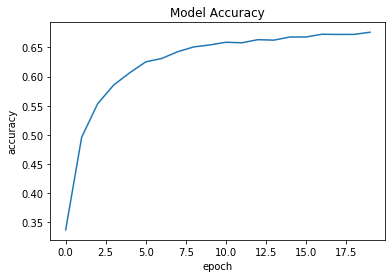

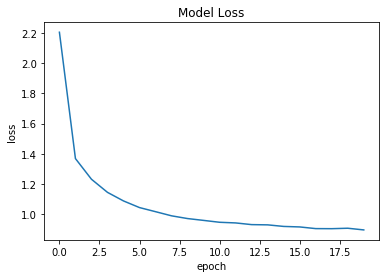

In [27]:
# Get the test accuracy
vgg_acc = vgg16.evaluate(test_features, y_test, verbose = 0)
print("\n")
print(vgg_acc)


# Plot the loss
plt.plot(vggmodel.history['accuracy'])
plt.title("Model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(vggmodel.history["loss"])
plt.title("Model Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

The test accuracy is about 70%, the train accuracy is around 67%. This model also shows no tendency of fitting.

# 3. Text Classification


## 3.1 RNN

In [9]:
# Load the data
text = pd.read_csv('twitter-data/tweets_with_labels.csv',sep='\t')
text.head()

,id,tweet,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15
0,1,Jazz for a Rainy Afternoon: {link},0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0
1,2,RT: @mention: I love rainy days.,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0
2,3,Good Morning Chicago! Time to kick the Windy C...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0
3,6,Preach lol! :) RT @mention: #alliwantis this t...,0.0,0.0,0.0,0.0,0.0,0.0,0.604,0.0,0.196,0.0,0.0,0.0,0.201,0.0,0.0
4,9,@mention good morning sunshine,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,1.000,0.0,0.0


In [19]:
# Process the tweets
def process(tweets):
    tweets_clean=[]

    for tweet in tweets:

        # Process text
        tokens = nltk.casual_tokenize(tweet)

        # Remove URL
        tokens =[term for term in tokens if not term.startswith('{') ]

        # Remove profiles
        tokens1 = [term for term in tokens if not term.startswith('@')]

        # Remove punctuation
        punctuation = list(string.punctuation)
        tokens2 = [term for term in tokens1 if term not in punctuation]

        # Remove hashtags
        tokens3 = [term for term in tokens2 if not term.startswith('#')]
        
        if tokens3 != []:
            
            sentence3 = ' '.join(tokens3)
        else:
            sentence3 = 'no words left'
        
        tweets_clean.append(sentence3)
    
    return tweets_clean

In [20]:
# Get the clean data
text['tweet_clean'] = process(text['tweet'])
text_clean = text[text['tweet_clean']!= 'no words left']

text_clean.head()

,id,tweet,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15,tweet_clean
0,1,Jazz for a Rainy Afternoon: {link},0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0,Jazz for a Rainy Afternoon link
1,2,RT: @mention: I love rainy days.,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0,RT I love rainy days
2,3,Good Morning Chicago! Time to kick the Windy C...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,Good Morning Chicago Time to kick the Windy Ci...
3,6,Preach lol! :) RT @mention: #alliwantis this t...,0.0,0.0,0.0,0.0,0.0,0.0,0.604,0.0,0.196,0.0,0.0,0.0,0.201,0.0,0.0,Preach lol :) RT this type of weather all the ...
4,9,@mention good morning sunshine,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,1.000,0.0,0.0,good morning sunshine


In [21]:
text2 = text_clean['tweet_clean']
label =  text_clean.iloc[:,2:-1].values

In [22]:
# Split the data
text_train,text_test,label_train,label_test = train_test_split(text2,label,test_size=0.3,random_state=123)

tokenizer = Tokenizer(num_words=500)
tokenizer.fit_on_texts(text_train)
train_sequences = tokenizer.texts_to_sequences(text_train) 
test_sequences = tokenizer.texts_to_sequences(text_test)

text_train_2 = pad_sequences(train_sequences,maxlen=50)
text_test_2 = pad_sequences(test_sequences,maxlen=50)


# Split train data into training data and validation data
train_text = text_train_2[:40000]
train_label = label_train[:40000]

val_text = text_train_2[40000:]
val_label = label_train[40000:]

In [23]:
# Train LSTM model
rnn= Sequential()
rnn.add(Embedding(500, 64))
rnn.add(LSTM(64))
rnn.add(Dense(15, activation ='sigmoid'))
rnn.compile(optimizer = 'rmsprop',loss = 'binary_crossentropy',metrics=['acc'])
rnn_history = rnn.fit(train_text,train_label,epochs = 15,validation_data = (val_text, val_label), batch_size = 128,verbose=1)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 40000 samples, validate on 14530 samples
Epoch 1/15
40000/40000 [==============================] - 61s 2ms/step - loss: 0.2228 - acc: 0.8746 - val_loss: 0.1681 - val_acc: 0.8916
Epoch 2/15
40000/40000 [==============================] - 66s 2ms/step - loss: 0.1490 - acc: 0.8988 - val_loss: 0.2286 - val_acc: 0.8508
Epoch 3/15
40000/40000 [==============================] - 62s 2ms/step - loss: 0.1268 - acc: 0.9063 - val_loss: 0.1227 - val_acc: 0.9089
Epoch 4/15
40000/40000 [==============================] - 60s 2ms/step - loss: 0.1183 - acc: 0.9088 - val_loss: 0.1160 - val_acc: 0.9108
Epoch 5/15
40000/40000 [==============================] - 68s 2ms/step - loss: 0.1132 - acc: 0.9099 - val_loss: 0.1143 - val_acc: 0.9107
Epoch 6/15
40000/40000 [==============================] - 59s 1ms/step - loss: 0.1104 - a

In [24]:
rnn_loss, rnn_acc = rnn.evaluate(text_test_2, label_test)

# Print out the test error
print('The loss of test data is:', rnn_loss)
print('The accuray of test data is: ', rnn_acc)

23370/23370 [==============================] - 23s 986us/step
The loss of test data is: 0.10510752594873952
The accuray of test data is:  0.9113850593566895


## 3.2 CNN

In [28]:
# Train CNN model
cnn2 = Sequential()
cnn2.add(Embedding(500,64))
cnn2.add(Conv1D(64, kernel_size = 3,padding='valid',activation='relu',strides=1))
cnn2.add(GlobalMaxPooling1D())
cnn2.add(Dropout(0.3))
cnn2.add(Dense(64,activation='relu'))
cnn2.add(Dense(15,activation='sigmoid'))
cnn2.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=['acc'])
cnn_history = cnn2.fit(train_text,train_label,epochs = 15,validation_data = (val_text, val_label), batch_size = 64,verbose=1)

Train on 40000 samples, validate on 14530 samples
Epoch 1/15
40000/40000 [==============================] - 14s 354us/step - loss: 0.1890 - acc: 0.8877 - val_loss: 0.1151 - val_acc: 0.9106
Epoch 2/15
40000/40000 [==============================] - 13s 322us/step - loss: 0.1209 - acc: 0.9083 - val_loss: 0.1097 - val_acc: 0.9124
Epoch 3/15
40000/40000 [==============================] - 13s 322us/step - loss: 0.1158 - acc: 0.9093 - val_loss: 0.1073 - val_acc: 0.9127
Epoch 4/15
40000/40000 [==============================] - 13s 321us/step - loss: 0.1126 - acc: 0.9100 - val_loss: 0.1068 - val_acc: 0.9127
Epoch 5/15
40000/40000 [==============================] - 13s 323us/step - loss: 0.1108 - acc: 0.9102 - val_loss: 0.1062 - val_acc: 0.9129
Epoch 6/15
40000/40000 [==============================] - 13s 327us/step - loss: 0.1093 - acc: 0.9105 - val_loss: 0.1055 - val_acc: 0.9128
Epoch 7/15
40000/40000 [==============================] - 13s 324us/step - loss: 0.1080 - acc: 0.9107 - val_loss: 0.

In [29]:
cnn_loss, cnn_acc = cnn2.evaluate(text_test_2, label_test)

# Print out the test error
print('The loss of test data is:', cnn_loss)
print('The accuray of test data is: ', cnn_acc)

23370/23370 [==============================] - 3s 143us/step
The loss of test data is: 0.10519244439794714
The accuray of test data is:  0.9115474820137024


For these two models, I used binary cross entropy instead of categorical cross entropy. Because binary cross entropy improves a lot in the speed of training the model, but retains the accuracy of the model.

## 3.3 ROC curve

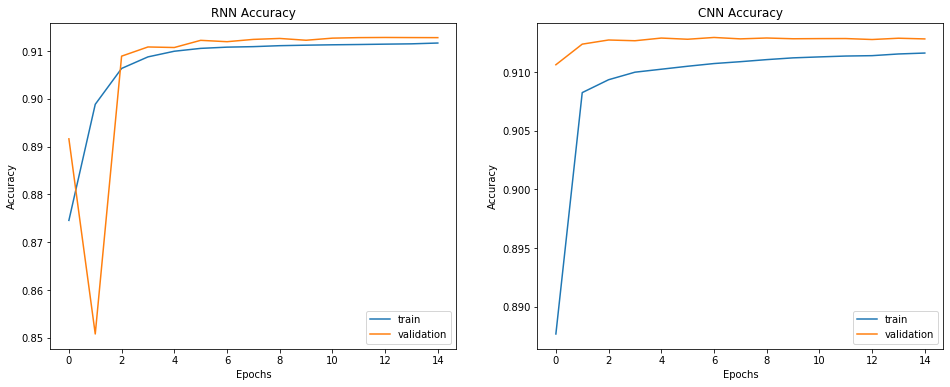

In [30]:
# Plot the results
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['acc'])
plt.plot(rnn_history.history['val_acc'])
plt.title('RNN Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['acc'])
plt.plot(cnn_history.history['val_acc'])
plt.title('CNN Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

From the plots, we can see that the validation accuracy for RNN model has a drop around epoch 2, but increases from epoch 2 and even higher than train accuracy. For CNN, validation accuracy is always higher than train accuracy, and even is high at the beginning of that training process. Overall, these two model perform very well, none of them have the tendency of overfitting.